# Artificial Quantum Life:

Esta presentacion surge a partir del essay: Quantum Artificial Life in an IBM Quantum Computer.

En este cuaderno mostramos la forma en la que hemos implementado la creacion de vida artificial y sus procesos de reproduccion. Dentro de estos se encuentran los siguientes:
- Asexual
- Sexual

Asimismo, proporcionamos un conjunto de metodos para la creacion de estos circuitos y el analisis de los mismos.

In [3]:
from qiskit import *
from qiskit.aqua.circuits.gates import cry

from qiskit.visualization import plot_histogram

import numpy as np
import random

import sys
import matplotlib.pyplot as plt

Los siguientes parametros se establecen para las configuraciones iniciales de los circuitos

In [4]:
theta = 2*np.pi/3
thetaR = np.pi/4

fileNum = 30

In [5]:
# Chose your prefered backend
sim = Aer.get_backend('qasm_simulator') 

# Devuelve el valor esperado de un circuito con un solo bit de registro
def getExpectedValue(qc, shots=8192):
    job = execute(qc, sim, shots=shots)

    count = job.result().get_counts()
    a,b = [count[a]/shots if a in count else 0 for a in ['0','1']]
    return a-b

def printHistogram(qc, shots=8192):
    job = execute(qc, sim, shots=shots)
    return plot_histogram(job.result().get_counts())


A la hora de simular el paso del tiempo y sus consecuencias sobre el individuo, hemos optado por agregar una ancilla la cual degenerara el fenotipo. 

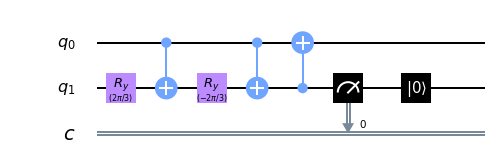

In [99]:
# Devuelve la Gate time_Lapse que aplica una iteracion de paso de tiempo
# 
# Changed : Float que representa el valor en radianes del gate CRY
def getDecoherence(changed):
    decoherenceG = QuantumCircuit(2,1, name='decoherence')
    decoherenceG.ry(changed,1)
    decoherenceG.cx(0,1)
    decoherenceG.ry(-changed,1)
    decoherenceG.cx(0,1)
    decoherenceG.cx(1,0)
    decoherenceG.measure([1],[0])
    decoherenceG.reset(1)
    return decoherenceG


## Creacion y clonacion de individuos

Un circuito simulador es un conjunto de pasos de tiempo con unas pautas de clonacion de elementos. El proceso de creacion de un individuo comenzaria establecendiendo un estado a el qbit del genotipo del individuo inicial. Esto se puede hacer aplicando una puerta U3 con un angulo en _x_. A continuacion, clonamos el genotipo sobre el fenotipo aplicando un CNOT:

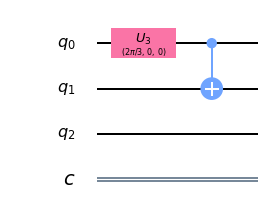

Una vez creado el individuo inicial, comenzariamos la simulacion dejando pasar una cantidad de tiempo que deseemos. En este caso aplicaremos solo 1 unidad de tiempo. Entonces, decidiremos clonar el individuo inicial. Para este proceso tendremos que copiar primero el genotipo del individuo inicial sobre otro qbit del segundo inidividuo y depues, copiaremos el valor del genotipo del segundo individuo sobre su fenpotipo:

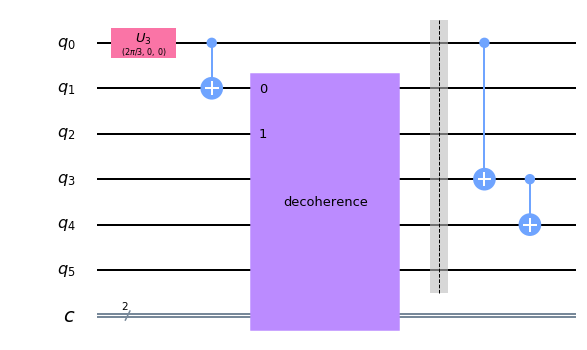

Este proceso puede extenderse de forma arbitraria, creando poblaciones tan grandes como queramos. Asimismo, podemos optar por limitar el numero de habitantes pero establecer una cantidad de tiempo tan larga como deseemos.


## Poblaciones no relacionadas

Algunas veces, no buscaremos clonar la poblacion, sino tener una poblacion inicial de _n_ habitantes y aplicar varias las iteraciones de tiempo sobre la poblacion y comprobar el estado de la misma. Dentro de estas poblaciones 


In [53]:
# Crea un circuito general de una Artificial Life de poblacion 1
#
# time    : Integer representando la cantidad de iteraciones
# initial : Float que representa los radiones de la gate U3 inicial
# changed : Float que representa los radianes de la gate CRY
# pop     : Integer representando la cantidad de poblacion que tendra el algoritmo
def getCircuit(pop=1,time=3, initial=theta, changed=theta, measure = True):
    decoherenceG = getDecoherence(changed).to_instruction()
    
    qc = QuantumCircuit(3*pop,pop)
    for i in range(pop):
        qc.u3(initial,0,0,i*3)
        qc.cx(i*3,i*3+1)
    qc.barrier()
    for i in range(0,time):
        #cry
        for j in range(pop):
            qc.append(decoherenceG, [j*3+1,j*3+2],[j])
        qc.barrier()
    if(measure):
        qc.measure([3*j+1 for j in range(pop)],[j for j in range(pop)])
    return qc


# Aumenta el la cantidad de capas de tiempo del circuito.
def addTimeLapse(qc,time,measure=False, changed = theta):
    decoherenceG = getDecoherence(changed).to_instruction()
    
    qBits = int(len(qc.qubits)/3)
    for i in range(0,time):
        #cry
        for j in range(qBits):
            qc.append(decoherenceG, [j*3+1,j*3+2],[j])
        qc.barrier()
    if(measure):
        qc.measure([3*j+1 for j in range(pop)],[j for j in range(pop)])
    


# Crea un escenario general de clonacion de poblacion asexual mediante clonacion exponencial
#
# time    : Integer representando la cantidad de iteraciones 
# pop     : Integer representando la cantidad de poblacion que tendra el algoritmo
# initial : Float que representa los radiones de la gate U3 inicial
# changed : Float que representa los radianes de la gate CRY
# mutationRate : Float que representa el ratio de mutacion
def getCircuitG(time=3, pop=2, initial=theta, changed=theta, mutationRate = 0, mutation=False):
    decoherenceG = getDecoherence(changed).to_instruction()
    
    qc = QuantumCircuit(3*pop,pop)
    qc.u3(initial,0,0,0)
    qc.cx(0,1)
    
    actPop = 1
    qc.barrier()
    for i in range(0,time):
        # Adding the new population
        actPopi = actPop
        for z in range(0,min(actPop, pop-actPop)):      
            qc.cx(3*z, 3*actPopi)
            if mutation:
                x = np.random.normal(loc=0, scale=mutationRate)
                qc.rx(x, 3*actPopi)
                y = np.random.normal(loc=0, scale=mutationRate)
                qc.ry(y, 3*actPopi)
                
            qc.cx(3*actPopi, 3*actPopi+1)
            actPopi+=1
        actPop = actPopi
        # Adding the Time_Lapse gates
        for j in range(0,pop):
            qc.append(decoherenceG, [3*j+1,3*j+2],[j])
        qc.barrier()
    qc.measure([3*j+1 for j in range(pop)],[j for j in range(pop)])
    return qc


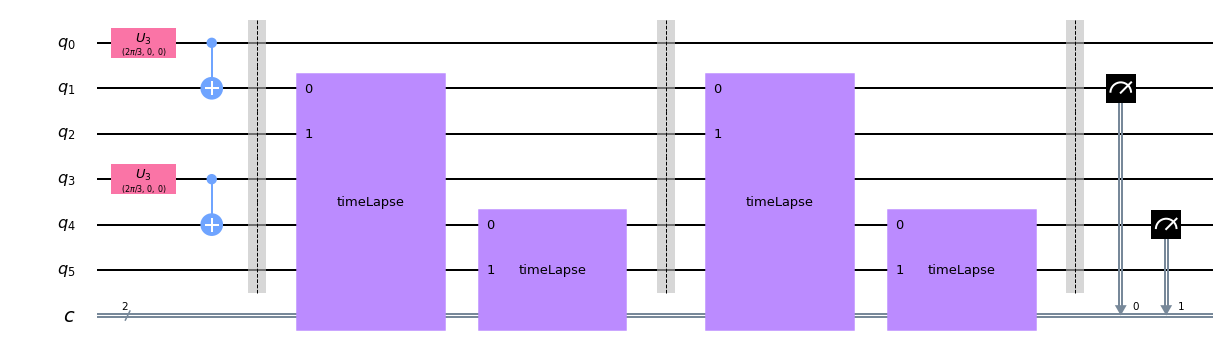

In [77]:
getCircuit(pop=2, time=2).draw(output='mpl')

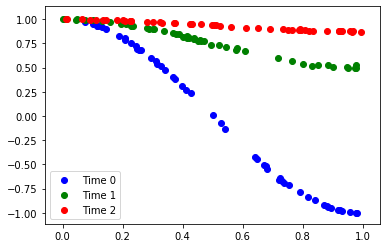

In [63]:
color = ["b","g","r"]

def checkPopulationParameters(shot = 50, timeSet = [0,1,2], parameter = "changed"):
    global fileNum
    for j in range(0,len(timeSet)):
        x =  []
        y = []

        for i in range(int(shot)):
            if(i%10==0):
                sys.stdout.write(f"Work progress: Iteration {j} - {100*float(i)/(shot)}%   \r" )
                sys.stdout.flush()
            rand = random.uniform(0, 1)
            x+= [rand]
            timeT = timeSet[j]
            if (parameter=="changed"):
                qc = getCircuit(time = timeT, changed=rand*np.pi)
                
            elif(parameter=="initial"):
                qc = getCircuit(time = timeT, initial=rand*np.pi)
            y += [getExpectedValue(qc)]
        plt.scatter(x, y,c=color[j], label=f"Time {timeSet[j]}")


    plt.legend(loc="lower left")
    plt.savefig(f"file_RA{fileNum}_N{shot}.png")
    fileNum+=1
checkPopulationParameters(parameter="initial")

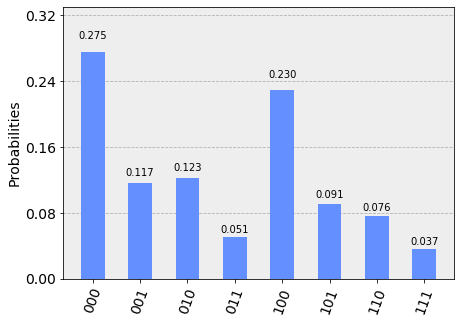

In [87]:
qc = getCircuitG(time=3,pop=3, initial=np.pi, changed = np.pi/5)
printHistogram(qc, shots=1000)

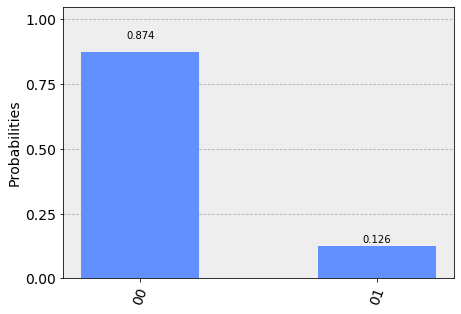

In [76]:


qc = QuantumCircuit(4,2)
qc.u3(2*np.pi/3,0,0,0)
qc.u3(np.pi/3,0,0,1)
qc.cx(1,3)
qc.ry(3*np.pi/4,3)
qc.cx(1,3)
qc.ry(-3*np.pi/4,3)
qc.cx(1,3)

qc.barrier()
qc.barrier()
qc.measure([3],[0])
qc.draw()
printHistogram(qc)

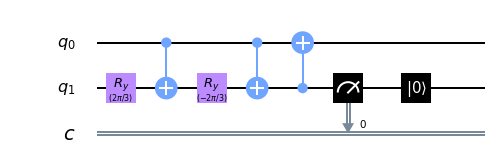

In [79]:
getDecoherence(theta).draw(output='mpl')

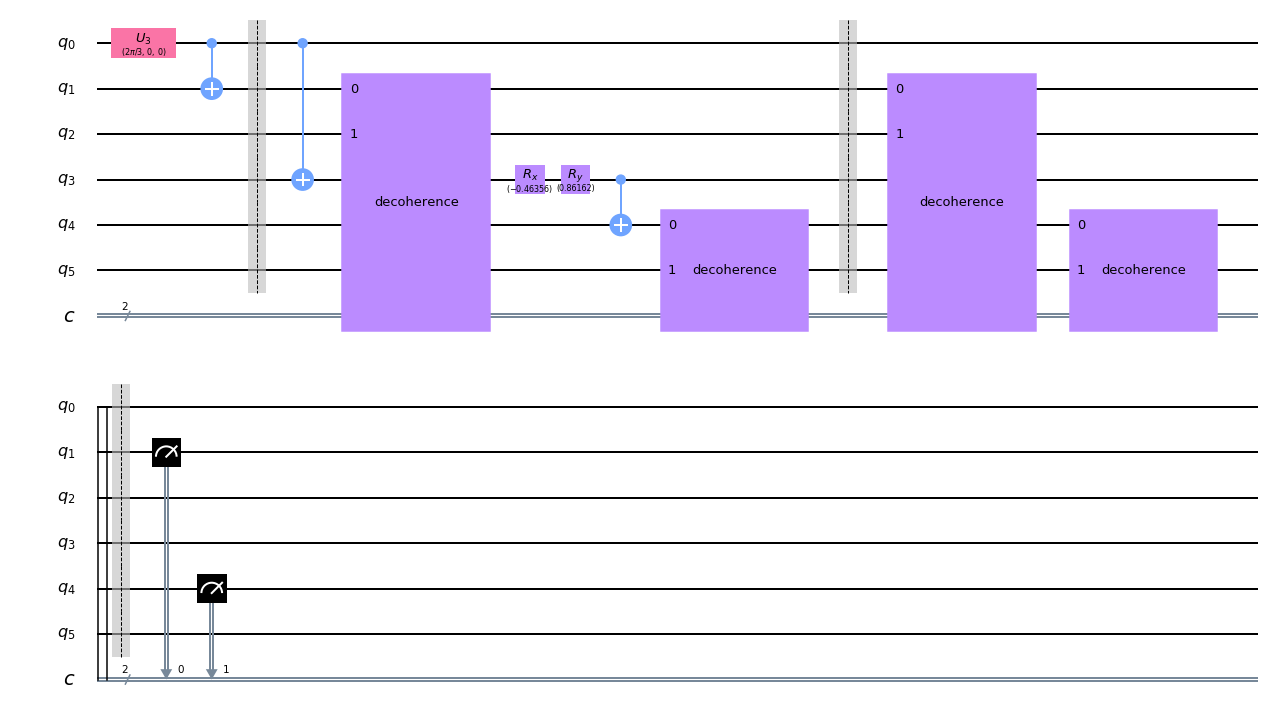

In [106]:
qc = getCircuitG(pop=2, time=2,mutation=True, mutationRate=0.5)
#addTimeLapse(qc, time=3)
qc.draw(output='mpl')

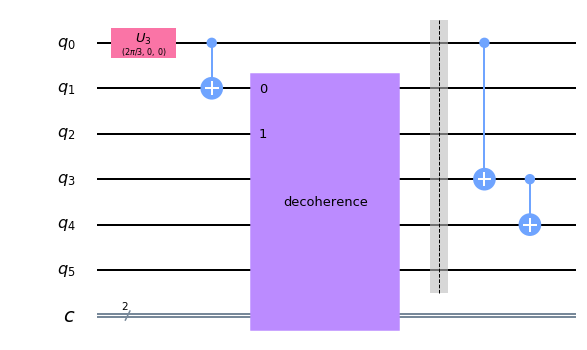

In [108]:
qc = QuantumCircuit(6,2)
qc.u3(2*np.pi/3,0,0,0)
qc.cx(0,1)
decoherenceG = getDecoherence(theta).to_instruction()
qc.append(decoherenceG, [1,2],[0])
qc.barrier()
qc.cx(0,3)
qc.cx(3,4)
qc.draw(output='mpl')